# DSC Essentials, Part 1

In this tutorial, you will get acquainted with the basic features of DSC through a simple example. 

This is a working example—optionally, you may [install DSC](../installation.html), and try running this example DSC program as you read through the tutorial.

## An illustration: the simulate-analyze-score design pattern

Suppose we want to compare several methods for a particular inference task, denoted by $I$. For example, $I$ could be:

+ Predict the missing entries of a matrix;

+ Estimate a covariance matrix from a data sample; 

+ Estimate a regression function relating outcome $Y$ to covariates (features) $X$.

For these three tasks, and others, we could conduct a benchmarking experiment to compare methods to perform $I$ by repeating the following three steps:

  1. Simulate some data suitable for performing $I$.
  
  2. Analyze the data with a method designed to perform $I$.
  
  3. Score how well the method performed $I$ (e.g., by comparing the methods' estimates against the ground-truth provided by the simulation).

DSC can handle more complex settings than this, but this basic structure suffices to explain the key concepts. We call this basic structure the "simulate-analyze-score" design pattern.

## The DSC building blocks: modules, groups and pipelines

Typically we will want to try different ways of implementating steps 1–3; that is, different ways to simulate the data, different ways to analyze the data, and different ways to score how well a method performed. 

In DSC, each different way of implementing a step is expressed as a "module". A "group of modules" defines the collection of alternative implementations of a step.

In our example, we define:

1. A group of `simulate` modules, each of which can perform step 1;

2. A group of `analyze` modules, each of which can perform step 2; and 

3. A group of `score` modules, each of which can perform step 3. 

Running the benchmark then consists of running sequences of modules—called "pipelines" in DSC—and each pipeline invokes one module from the `simulate` group, followed by a module from the `analyze` group, then a module from the `score` group.

DSC provides a flexible and easy-to-use language to manage and run benchmarks like these, as well as more complex ones. The modular design of DSC makes it easy to extend benchmarks (e.g., by defining a new `analyze` module)—hence the *Dynamic* in Dynamic Statistical Comparisons. 

Also, DSC efficiently uses the available computational resources by running modules in parallel when possible; for example, once a `simulate` module has created a dataset, DSC may run multiple `analyze` modules in parallel.

## Running a DSC benchmark

There are three essential ingredients to a DSC benchmark:

1. A "DSC file", which defines the modules, groups and pipelines, and how information flows from one module to another. The DSC file is a text file written in DSC syntax, as we show below (this syntax is explained in more detail in [Part II of the Introduction](First_Course_Elaborated.html)). 

2. A call to the `dsc` command-line program. This runs all pipelines defined by the DSC file, and saves the results to files in a structured way that makes them easy to query.

3. Query and summarize the results. We provide two querying interfaces. In this tutorial, we will demonstrate the R interface, which provides a convenient way of reading the DSC results into a data frame in R. We also provide a command-line tool, `dsc-query`, which is demonstrated in other tutorials.

## Example

We now illustrate how DSC can be used to implement a simple benchmark. 

In this example, we have a simple task: *estimate the mean of a population given a random sample from the population.*

We compare two methods for estimating the population mean: the sample mean and the sample median. 

We simulate under two different population distributions: a *t* distribution and a normal distribution. 

And we compute accuracy of the estimatesusing two different metrics: squared error, and absolute error.

## The DSC file

We implement this DSC in [R](https://cran.r-project.org/). Material used, including the DSC file, 
can be found in the [DSC vignettes repository](https://github.com/stephenslab/dsc/tree/master/vignettes/one_sample_location). 

Here, we give only a high-level overview of the DSC file, `first_investigation.dsc`, deferring a more detailed explanation of the syntax to [Part II of the Introduction](First_Course_Elaborated.html). This is the DSC file:

```
# Simulate samples from the normal distribution with mean 0 and
# standard deviation 1.
normal: R(x <- rnorm(n,mean = mu,sd = 1))
  mu: 0
  n: 100
  $data: x
  $true_mean: mu

# Simulate samples from the non-centered t-distribution with 3 degrees
# of freedom.
t: R(x <- mu + rt(n,df = 2))
  mu: 3
  n: 100
  $data: x
  $true_mean: mu

# Estimate the population mean by computing the mean value of the
# provided sample.
mean: R(y <- mean(x))
  x: $data
  $est_mean: y

# Estimate the population mean by computing the median value of the
# provided sample.
median: R(y <- median(x))
  x: $data
  $est_mean: y

# Compute the error in the estimated mean by taking the squared
# difference between the true mean and the estimated mean.
sq_err: R(e <- (x - y)^2)
  x: $est_mean
  y: $true_mean
  $error: e

# Compute the error in the estimated mean by taking the absolute
# difference between the true mean and the estimated mean.
abs_err: R(e <- abs(x - y))
  x: $est_mean
  y: $true_mean
  $error: e

DSC:
  define:
    simulate: normal, t
    analyze: mean, median
    score: abs_err, sq_err
  run: simulate * analyze * score
```

This DSC file defines six modules: 

+ two `simulate` modules  (`normal` and `t`),

+ two `analyze` modules (`mean` and `median`), and

+ two `score` modules (`sq_err` and `abs_err`). 

Each module in this example involves only one line of R code (for more complex modules, the code can live in separate files).

The DSC file then defines the module groups (`simulate`, `analyze` and `score`) and the pipelines to run; `simulate * analyze * score` indicates that all sequences of the `simulate`, `analyze` and `score` modules should be run.

## Run DSC 

To run DSC, we first change the working directory to the location of the `first_investigation.dsc` file. (Here we assume the `dsc` repository is stored in the `git` subdirectory of your home directory. If you are running the example yourself, please move to the appropriate directory on your computer.)

In [2]:
cd ~/git/dsc/vignettes/one_sample_location
pwd

/Users/pcarbo/git/dsc/vignettes/one_sample_location


If there are any previously generated results, let's remove them before moving on.

In [3]:
rm -Rf first_investigation.html first_investigation.log first_investigation 

Now we use the `dsc` command-line program to run 10 replicates of this benchmark (each replicate uses a different sequence of pseudorandom numbers to simulate the data), with 2 threads:

In [9]:
dsc first_investigation.dsc --replicate 10 -c 2

INFO: DSC script exported to first_investigation.html
INFO: Constructing DSC from first_investigation.dsc ...
INFO: Building execution graph & running DSC ...
DSC: 100%|██████████████████████████████████████| 15/15 [00:25<00:00,  1.24s/it]
INFO: Building DSC database ...
INFO: DSC complete!
INFO: Elapsed time 27.428 seconds.


(For first time users of DSC, a companion `R` package `dscrutils` should automatically installed at this point.)

When run, DSC will create results files in the folder `first_investigation` (this is the default folder name, and it can be changed in the DSC file). Below, we will see how to query these results and read them into R.

In addition, DSC will create a webpage summarizing the results (in this example, it is `first_investigation.html`). This file allows you to conveniently browse the DSC file, the executed pipelines, and the corresponding source code.

## Query the results

Next, we will read the results into R using the `dscquery` function from the `dscrutils` package. To do so, change the working directory in R to the location of the `first_investigation.dsc` file.

In [11]:
setwd("~/git/dsc/vignettes/one_sample_location")

Since this example is small, it is convenient to load all the results into an R data frame and explore the data frame interactively in the R environment. In more complex examples, one might want to start by extracting subsets of results using query conditions; type `help(dscquery)` in R for more information.

In [12]:
library(dscrutils)
dscout <- dscquery(dsc.outdir = "first_investigation",
                   targets    = c("simulate","analyze","score.error"))

Running shell command:
dsc-query first_investigation -o /var/folders/9b/ck4lp8s140lcksryyh4dppdr0000gn/T//RtmpiqKwJK/file1eb1225c20e7.csv -f --target simulate analyze score.error 
Loading dsc-query output from CSV file.
Reading DSC outputs:
 - score.error: extracted atomic values


In [13]:
head(dscout)

DSC,simulate,simulate.output.file,analyze,analyze.output.file,score,score.error
1,normal,normal/normal_1,mean,mean/normal_1_mean_1,abs_err,0.19718
2,normal,normal/normal_2,mean,mean/normal_2_mean_1,abs_err,0.09914
3,normal,normal/normal_3,mean,mean/normal_3_mean_1,abs_err,0.07965
4,normal,normal/normal_4,mean,mean/normal_4_mean_1,abs_err,0.20177
5,normal,normal/normal_5,mean,mean/normal_5_mean_1,abs_err,0.02788
6,normal,normal/normal_6,mean,mean/normal_6_mean_1,abs_err,0.14856


Once the results are in an R data frame like this, we can easily use standard functions in R to investigate them further.

For example, we can generate an informative summary of the results using the `aggregate` function, followed by a call to the `order` function to arrange the rows so that it is easier to compare the mean and median estimates:

In [6]:
dscsummary <- aggregate(score.error ~ simulate + analyze + score,dscout,mean)
dscsummary[with(dscsummary,order(simulate,score)),]

,simulate,analyze,score,score.error
1,normal,mean,abs_err,0.11442
3,normal,median,abs_err,0.10922
5,normal,mean,sq_err,0.01756
7,normal,median,sq_err,0.01878
2,t,mean,abs_err,0.35712
4,t,median,abs_err,0.08659
6,t,mean,sq_err,0.60042
8,t,median,sq_err,0.01281


From this summary, we see that the median is a more accurate estimate of the population mean for *t*-distributed data (on average), and it is also a better estimate for normally distributed data judging as measured by the absolute error—but it is not better if we look at the squared differences.

## Visualize the results

Next, we demonstrate use of the `ggplot2` package to create a visual summary the squared-error results:

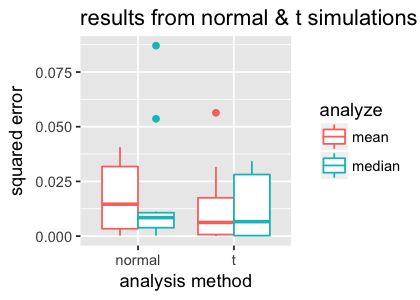

In [14]:
# Load the ggplot2 package and set up graphics within the Jupyter environment.
library(ggplot2)
library(repr)
options(repr.plot.width = 3.5,repr.plot.height = 2.5)

# This function selects the DSC results with the squared-error metric only, 
# removing unusually large errors, then creates a combined violin and dotplot 
# summarizing the accuracy of the two analysis methods ("mean" and "median").
create.boxplot <- function (dat) {
  pdat <- subset(dat,score == "sq_err" & score.error < 0.1)
  return(qplot(x = simulate,y = score.error,data = pdat,color = analyze,geom = "boxplot",
               xlab = "analysis method",ylab = "squared error",
               main = "results from normal & t simulations"))
}

create.boxplot(dscout)

Based on the results from the 10 replicates, we see that the median is substantially more accurate than the mean in the normal simulations, on average, and it yields only slightly worse accuracy in the *t* simulations.

## Expand the experiment

Above, we compared different ways to estimate the population mean from a sample, and examined the results of this comparison. We observed that the median estimate tends to be more accurate than the mean estimate. However, this was based on very little data—we only ran 10 replicates. 

Here, we increase the number of replicates to 20 to strengthen the conclusions we drew above. 

We will see that DSC does this efficiently; it determines the minimum effort needed to produce the new results, and only runs scripts if they are needed to generate new results.

In [15]:
dsc first_investigation.dsc --replicate 20 -c 2

INFO: DSC script exported to first_investigation.html
INFO: Constructing DSC from first_investigation.dsc ...
INFO: Building execution graph & running DSC ...
DSC: 100%|██████████████████████████████████████| 15/15 [00:25<00:00,  1.28s/it]
INFO: Building DSC database ...
INFO: DSC complete!
INFO: Elapsed time 27.675 seconds.


*NOTE: Gao will add a line to the summary indicating which module outputs are newly generated, and which are unchanged from a previous run. This needs to be done in SoS.*

From this summary, we see that X of the module outputs were generated in this DSC run, and Y module outputs are unchanged from the previous run, and therefore did not need to be generated again. Although the benefit is not particularly noticeable for this toy example, avoiding unnecessary computations can yield a huge payoff when running complex analyses or when working with very large data sets.

Let's now load the results from our expanded DSC run.

In [16]:
dscout2 <- dscquery(dsc.outdir = "first_investigation",
                    targets    = c("simulate","analyze","score.error"))

Running shell command:
dsc-query first_investigation -o /var/folders/9b/ck4lp8s140lcksryyh4dppdr0000gn/T//RtmpiqKwJK/file1eb132bc6dfb.csv -f --target simulate analyze score.error 
Loading dsc-query output from CSV file.
Reading DSC outputs:
 - score.error: extracted atomic values


Comparing to the previous `dscquery` output, we confirm that the new DSC run generated twice as many results.

In [17]:
nrow(dscout)
nrow(dscout2)

[1] 80

[1] 160

## Add a new method to the DSC benchmark

Another commonly used approach to estimate a population mean is the "Winsorized" estimator; this approach is more robust to unusually large and unusually small values because top and bottom value are trimmed. Here we use the Winsorized mean implemented in the [psych package](https://cran.r-project.org/package=psych).

To compare the Winsorized mean against the regular mean and median estimates, we add the following lines to our DSC file:

```
# Estimate the population mean by computing the Winsorized mean; the
# mean is computed after trimming the top and bottom 10% quantiles.
winsor: R(y <- psych::winsor.mean(x,trim,na.rm = TRUE))
  trim: 0.1
  x: $data
  $est_mean: y
```

This module is similar in structure to the `mean` and `t` modules; the main difference is the R code inside the `R()`.

To include the Winsorized mean method in our benchmark, we also need to add the winsor module to the "analyze" module group:

```
DSC:
  define:
    simulate: normal, t
    analyze: mean, median, winsor
    score: abs_err, sq_err
  run: simulate * analyze * score
  output: first_investigation
```

Similar to adding new replicates, we will see that DSC does the minimum computation needed to augment the benchmark with the Winsorized mean method.

In [18]:
dsc add_winsor_method1.dsc --replicate 20 -c 2

INFO: DSC script exported to first_investigation.html
INFO: Constructing DSC from add_winsor_method1.dsc ...
INFO: Building execution graph & running DSC ...
DSC: 100%|██████████████████████████████████████| 21/21 [00:29<00:00,  1.97s/it]
INFO: Building DSC database ...
INFO: DSC complete!
INFO: Elapsed time 31.912 seconds.


Since the addition of the `winsor` module has no effect on the results generated using the mean and median methods, the DSC program automatically determines that the previously generated results for these methods are still valid, and does not re-run the R code.

Let's load the results from our new benchmark into R.

In [19]:
dscout3 <- dscquery(dsc.outdir = "first_investigation",
                    targets    = c("simulate","analyze","score.error"))

Running shell command:
dsc-query first_investigation -o /var/folders/9b/ck4lp8s140lcksryyh4dppdr0000gn/T//RtmpiqKwJK/file1eb11ab17408.csv -f --target simulate analyze score.error 
Loading dsc-query output from CSV file.
Reading DSC outputs:
 - score.error: extracted atomic values


As before, we can easily create a visual summary of the squared-error results:

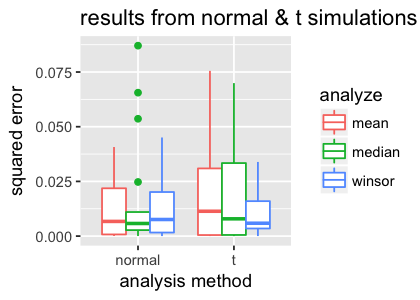

In [20]:
create.boxplot(dscout3)

From this plot, we observe that the Winsorized mean estimate is more accurate than both the standard mean and median on the *t*-distributed data.

## Recap

In this tutorial, we presented a very simple example of a DSC benchmark. Despite its simplicity, this example was useful for illustrating some of the essential features of DSC:

1. A DSC experiment can be decomposed into *modules*;

2. The modules can be organized into *module groups*;

3. The modules and module groups and combined in sequence, forming *pipelines*;

4. Pipelines can easily be replicated with different pseudorandom number sequences;

5. The results of a DSC experiment can be conveniently loaded into a data frame in R, and the results can be examined using standard tools and packages in R.

6. When updating or extending a benchmark, DSC generates the results [dynamically](https://en.wikipedia.org/wiki/Dynamic_programming)—that is, DSC determines the minimum computational effort needed to update or extend the results.

## Next steps

To learn more about the syntax of the DSC file so that you can develop your own DSCs, read [Part II of this Introduction to DSC](First_Course_Elaborated.html).